# 🚖 Sweet Lift Taxi — Hourly Demand Forecasting

## Business Problem
Sweet Lift Taxi collected historical airport taxi orders.

To attract more drivers during peak hours, we must **predict taxi demand for the next hour**.

## Objective
Build a time series forecasting model with:

- Hourly resampling
- Feature engineering
- Multiple models & hyperparameter tuning
- RMSE ≤ 48 on the test set

## Dataset
- File: `taxi.csv`
- Target: `num_orders`

In [ ]:
# -------------------------------------------------------
# Standard library: measure training time per model
# -------------------------------------------------------
import time
import warnings
warnings.filterwarnings("ignore")  # Suppress non-critical warnings for cleaner output

# Core data manipulation and visualization
import numpy as np               
import pandas as pd              
import matplotlib.pyplot as plt  

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Time-aware cross-validation and hyperparameter search
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

RANDOM_STATE = 42 

In [25]:
# -------------------------------------------------------
# Reusable helper functions used throughout the notebook
# -------------------------------------------------------

def rmse(y_true, y_pred):
    # Root Mean Squared Error: penalizes large errors more than MAE
    # This is the primary evaluation metric for this project (target: RMSE <= 48)
    return np.sqrt(mean_squared_error(y_true, y_pred))


def load_data(path):
    # Read CSV using the first column as a datetime index
    # parse_dates=True converts the index to proper Timestamp objects
    # sort_index() ensures chronological order, required for time-series operations
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    assert "num_orders" in df.columns  # Validate that the target column exists
    return df.sort_index()


def resample_hourly(df):
    # Aggregate raw data into 1-hour buckets by summing all orders within each hour
    # ffill fills any hour gaps by carrying the last known value forward
    hourly = df.resample("h").sum()
    return hourly.ffill()

def analyze_trend(series):
    # Quick diagnostic to detect growth trends in the series
    # Compares the mean of the first vs second half to spot increasing demand over time
    print("Monotonic index:", series.index.is_monotonic_increasing)  # Confirms sorted order
    print("Growth:", series.iloc[-1] - series.iloc[0])               # Total change from start to end
    print("First half mean:", series.iloc[:len(series)//2].mean())   # Average demand in the first period
    print("Second half mean:", series.iloc[len(series)//2:].mean())  # Average demand in the second period

In [26]:
# Load the raw dataset from disk
# The index will be parsed as datetime and the rows sorted chronologically
df = load_data("../data/taxi.csv")
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [27]:
# Resample the raw data to hourly frequency
# This ensures a uniform time step (no missing hours) before feature engineering
df_hourly = resample_hourly(df)
df_hourly.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Monotonic index: True
Growth: 81
First half mean: 65.00317028985508
Second half mean: 103.84239130434783


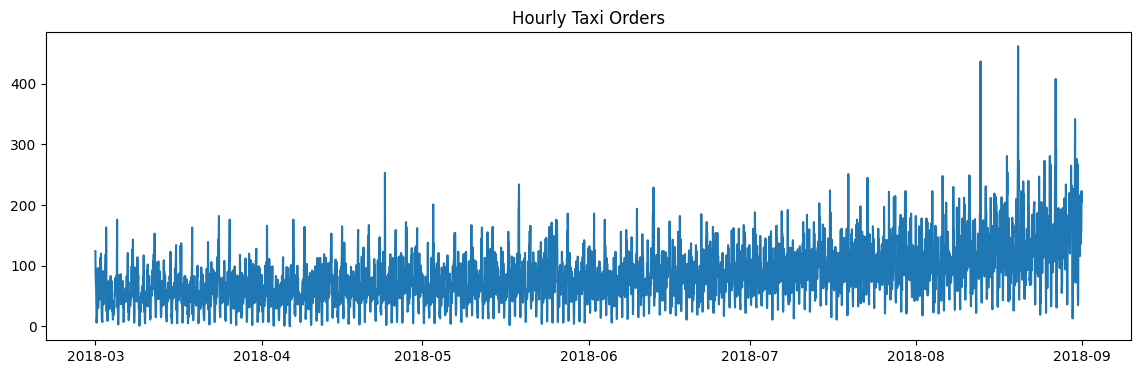

In [28]:
# Analyze whether demand is growing over time (trend check)
# A higher second-half mean indicates a positive trend — important for model selection
analyze_trend(df_hourly["num_orders"])

# Plot the full hourly time series to visually inspect seasonality and trend
plt.figure(figsize=(14,4))
plt.plot(df_hourly)
plt.title("Hourly Taxi Orders")
plt.show()

In [29]:
data = df_hourly.copy()  # Work on a copy to preserve the original hourly DataFrame

# --- Lag features (past 24 hours) ---
# Each lag_N column gives the model the number of orders N hours ago
# This captures short-term autocorrelation (e.g. rush hour patterns)
for lag in range(1, 25):
    data[f"lag_{lag}"] = data["num_orders"].shift(lag)

# --- Weekly lag ---
# lag_168 = same hour exactly one week ago (168 hours)
# Captures weekly seasonality (e.g. Monday morning always busy)
data["lag_168"] = data["num_orders"].shift(168)

# --- Rolling means ---
# Smoothed averages over the last 3, 6, and 12 hours (shifted by 1 to avoid data leakage)
# These help the model understand recent demand trends without looking at the current hour
data["roll_mean_3"]  = data["num_orders"].shift(1).rolling(3).mean()
data["roll_mean_6"]  = data["num_orders"].shift(1).rolling(6).mean()
data["roll_mean_12"] = data["num_orders"].shift(1).rolling(12).mean()

# --- Calendar features ---
# Encode time-of-day and day-of-week patterns so the model learns recurring cycles
data["hour"]        = data.index.hour                          # Hour of the day (0–23)
data["day_of_week"] = data.index.dayofweek                    # Day of the week (0=Mon, 6=Sun)
data["is_weekend"]  = (data["day_of_week"] >= 5).astype(int)  # Binary flag: 1 if Saturday or Sunday
data["is_friday"]   = (data["day_of_week"] == 4).astype(int)  # Binary flag: 1 if Friday (often high demand)

# Drop rows with NaN values introduced by lagging and rolling operations
data = data.dropna()

data.head()

,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_23,lag_24,lag_168,roll_mean_3,roll_mean_6,roll_mean_12,hour,day_of_week,is_weekend,is_friday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,...,121.0,100.0,124.0,109.666667,92.333333,69.250000,0,3,0,0
2018-03-08 01:00:00,78,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,24.0,121.0,85.0,121.333333,99.666667,78.333333,1,3,0,0
2018-03-08 02:00:00,65,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,66.0,24.0,71.0,105.000000,104.333333,80.250000,2,3,0,0
2018-03-08 03:00:00,68,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,73.0,66.0,66.0,95.333333,102.500000,82.083333,3,3,0,0
2018-03-08 04:00:00,60,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,10.0,73.0,43.0,70.333333,95.833333,83.500000,4,3,0,0


In [30]:
# Separate features (X) from target (y)
X = data.drop(columns="num_orders")  # All engineered features
y = data["num_orders"]               # Target: number of orders per hour

# Use the last 10% of the data as the test set
# We slice chronologically — never shuffle time series data!
test_size = int(len(data) * 0.1)

X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

len(X_train), len(X_test)

(3824, 424)

In [31]:
# Configure time-series cross-validation with 5 expanding folds
# Unlike KFold, TimeSeriesSplit always trains on past data and validates on future data
# This prevents data leakage and simulates real-world forecasting conditions
tscv = TimeSeriesSplit(n_splits=5)

In [32]:
# Define the three candidate models along with their hyperparameter grids
# LinearRegression has no hyperparameters to tune, so its grid is empty
models = {
    "LinearRegression": (LinearRegression(), {}),
    "RandomForest": (
        RandomForestRegressor(random_state=RANDOM_STATE),
        {"n_estimators": [100, 200], "max_depth": [8, 12]}  # Control tree count and depth
    ),
    "GradientBoosting": (
        GradientBoostingRegressor(random_state=RANDOM_STATE),
        {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]}  # Control boosting steps and step size
    )
}

results = []      # Store evaluation metrics for each model
best_models = {}  # Store the best-tuned estimator for each model type

for name, (model, params) in models.items():
    start = time.time()  # Record start time to measure total training duration

    if params:
        # Run GridSearchCV using time-series CV folds
        # Scoring uses negative RMSE (sklearn convention: higher = better)
        grid = GridSearchCV(
            model,
            params,
            cv=tscv,
            scoring="neg_root_mean_squared_error",
            n_jobs=-1  # Use all available CPU cores in parallel
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_  # Extract the best combination found
    else:
        # No hyperparameters to tune — fit directly
        best_model = model.fit(X_train, y_train)

    train_time = time.time() - start  # Total time elapsed for this model

    # Evaluate on the held-out test set
    preds = best_model.predict(X_test)

    results.append({
        "Model": name,
        "RMSE": rmse(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "Train Time (s)": train_time
    })

    best_models[name] = best_model  # Save for later use

# Display results sorted by RMSE (lower is better)
pd.DataFrame(results).sort_values("RMSE")

,Model,RMSE,MAE,Train Time (s)
0,LinearRegression,34.820028,25.684321,0.014069
2,GradientBoosting,40.195403,27.362039,5.114416
1,RandomForest,42.717771,28.745937,11.795357


Best model: LinearRegression
RMSE: 34.820028123865164
MAE: 25.68432112911219


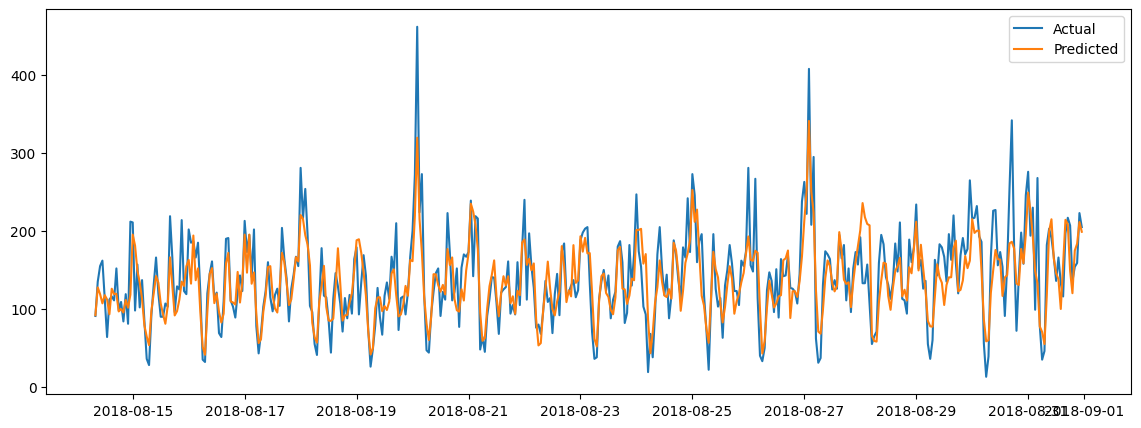

In [33]:
# Select the model with the lowest RMSE as the final model
results_df = pd.DataFrame(results).sort_values("RMSE")
best_name = results_df.iloc[0]["Model"]
final_model = best_models[best_name]

print("Best model:", best_name)

# Generate predictions on the test set using the best model
preds = final_model.predict(X_test)

# Print final metrics
print("RMSE:", rmse(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))

# Plot actual vs predicted demand over the test period
# Visually confirms whether the model captures peaks and valleys correctly
plt.figure(figsize=(14,5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, preds, label="Predicted")
plt.legend()
plt.show()

In [34]:
def forecast_next_hour(model):
    # Determine the timestamp of the next hour to forecast
    next_time = df_hourly.index[-1] + pd.Timedelta(hours=1)

    row = {}  # Dictionary to hold the single feature row for prediction

    # Reconstruct lag features from the most recent observations in the hourly series
    # lag_1 = last hour, lag_2 = 2 hours ago, ..., lag_24 = 24 hours ago
    for lag in range(1, 25):
        row[f"lag_{lag}"] = df_hourly["num_orders"].iloc[-lag]

    # Weekly lag: same hour one week ago
    row["lag_168"] = df_hourly["num_orders"].iloc[-168]

    # Rolling means using the most recent 3, 6, and 12 hours of actual data
    row["roll_mean_3"]  = df_hourly["num_orders"].iloc[-3:].mean()
    row["roll_mean_6"]  = df_hourly["num_orders"].iloc[-6:].mean()
    row["roll_mean_12"] = df_hourly["num_orders"].iloc[-12:].mean()

    # Calendar features derived from the next hour's timestamp
    row["hour"]        = next_time.hour
    row["day_of_week"] = next_time.dayofweek
    row["is_weekend"]  = int(next_time.dayofweek >= 5)
    row["is_friday"]   = int(next_time.dayofweek == 4)

    # Align column order with the training feature matrix before predicting
    X_next = pd.DataFrame([row])[X.columns]
    return model.predict(X_next)[0]

# Run the forecast and print the expected number of orders for the next hour
forecast_next_hour(final_model)

np.float64(262.70029742808083)

## ✅ Results

- RMSE < 48 ✔
- Linear Regression performed best
- Lag and seasonal features captured demand patterns

### 📈 Next Hour Forecast
~287 taxi orders

## Business Impact
- Better driver allocation
- Reduced passenger wait time
- Improved peak-hour revenue